# Emulate a production run and postprocessing training for existing TPS data

In this notebook we will first emulate an iterative production run from existing TPS data, i.e. we will not generate any new trajectories but train a model on the existing trajectory/shooting data. This can be done in wo different ways:
 - **emulate production** is trying to be as close as possible to the real simulation by adding the shooting results one by one to the trainingset in the order they have been produced. This is useful to quickly test different models/model architectures without the (computationally costly) trajectory propagation. Here we will do this on the LiCl data from the publication to reproduce those results.
 - **postprocessing training** usually gives the more accurate model, here we use the full training set from the begininng of the training on thereby avoiding issues that arise from correlations of subsequent shooting points and also do not have the issue that we train on a very limited amount of data as at the beginning of the iterative run
 
We will start with emulating a production run, then do a postprocessing training and finish by cross correalting the two model with each other and the sampled validation committors.

We will use the data in `training_and_validation_data`, which contains a `.npz` file with precalculated descriptors for the shooting points and the corresponding shooting reults. In that folder are also the results of validation committor shots for the single LiCl ion pair and for a 1 M LiCl solution to check the accuracy and transferability of the trained models. Additionally for every `.npz` file there is also a corresponding `mdtraj` `.h5` trajectory (with the suffix `_configurations.h5` instead of `_data.npz`) which contains the atomistic configurations of the shooting snapshots in case we want to try different descriptor functions to transform frrom the atomistic space to the space the model learns and predicts in.

In [1]:
# to be able to run multiple notebooks in paralell:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import aimmd
import mdtraj as mdt

In [4]:
# load the training data from the iterative run
# the descriptors here correspond to the full symmetry function description used in the publication,
# it is also what you get by removing the comments in the symmetry function setup from the iterative notebooks with "reduced symmetry functions"
f = np.load("training_and_validation_data/LiCl_training_data.npz")
trainset = aimmd.TrainSet(n_states=2, descriptors=f["descriptors"], shot_results=f["shot_results"])

In [5]:
# open an aimmd storage for model storing
aimmd_store = aimmd.Storage("emulate_and_pptrain_keras.h5")

## Emulate production

### Define a model

In [6]:
# ResNet setup
from tensorflow.keras import optimizers, regularizers
n_top = 10
n_lay = 5
n_base = trainset.descriptors.shape[1]
fact = (n_top / n_base)**(1./(n_lay-1))


hidden_parms = [{'units': max(1, int(n_base * fact**i)),
                 'activation': 'linear',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,
                 'bias_regularizer': None,
                 'activity_regularizer': None,
                 'kernel_constraint': None,
                 'bias_constraint': None,
                 'dropout': 0.1,
                }
                for i in range(1)]

hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                 'activation': 'elu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,
                 'bias_regularizer': None,
                 'activity_regularizer': None,
                 'kernel_constraint': None,
                 'bias_constraint': None,
                 'dropout': None,
                 'residual_n_skip': 4,
                }
                for i in range(1)]

for i in range(1, n_lay):
    hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                     'activation': 'linear',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': 0.1 * fact**i,
                     }
                    ]

    hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                     'activation': 'elu',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': None,
                     'residual_n_skip': 4,
                     }
                    ]

optimizer = optimizers.Adam(lr=1e-3)
# create a SNN with binomial loss to predict p_B
resnet = aimmd.keras.create_resnet(ndim=n_base, hidden_parms=hidden_parms,
                                   optimizer=optimizer, n_states=2,  # does not really matter if multi_state=False
                                   multi_state=False)

# wrap it for use with aimmd
model = aimmd.keras.EEScaleKerasRCModel(nnet=resnet,
                                        # since we already have the descriptors and the shooting results
                                        # our model does not need the 'real' states and descriptor transform
                                        states=["bound", "unbound"],  # just needs to have the correct length
                                        descriptor_transform=None,  # using None means use given descriptors as is without applying any transformation
                                        ee_params={'lr_0': 1e-3,
                                                   'lr_min': 1e-4,
                                                   'epochs_per_train': 1,
                                                   'interval': 3,
                                                   'window': 100,
                                                   'batch_size':128},
                                        cache_file=aimmd_store,
                                       )

In [7]:
# save initial model
aimmd_store.rcmodels["initial_model_emulation"] = model

# now do a production emulation using one of the utility functions
# (there is also a function to emulate a production run from an openpathsampling storage, but this is mainly useful if changing the descriptor_transform)
model = aimmd.emulate_production_from_trainset(model=model, trainset=trainset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
# save the model after training/emulating the production run
aimmd_store.rcmodels["final_model_emulation"] = model

## Postprocessing training

### Define a model
(same architecture as above)

In [9]:
# ResNet setup
from tensorflow.keras import optimizers, regularizers
n_top = 10
n_lay = 5
n_base = trainset.descriptors.shape[1]
fact = (n_top / n_base)**(1./(n_lay-1))


hidden_parms = [{'units': max(1, int(n_base * fact**i)),
                 'activation': 'linear',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,
                 'bias_regularizer': None,
                 'activity_regularizer': None,
                 'kernel_constraint': None,
                 'bias_constraint': None,
                 'dropout': 0.1,
                }
                for i in range(1)]

hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                 'activation': 'elu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,
                 'bias_regularizer': None,
                 'activity_regularizer': None,
                 'kernel_constraint': None,
                 'bias_constraint': None,
                 'dropout': None,
                 'residual_n_skip': 4,
                }
                for i in range(1)]

for i in range(1, n_lay):
    hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                     'activation': 'linear',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': 0.1 * fact**i,
                     }
                    ]

    hidden_parms += [{'units': max(1, int(n_base * fact**i)),
                     'activation': 'elu',
                     'use_bias': True,
                     'kernel_initializer': 'lecun_normal',
                     'bias_initializer': 'lecun_normal',
                     'kernel_regularizer': None,
                     'bias_regularizer': None,
                     'activity_regularizer': None,
                     'kernel_constraint': None,
                     'bias_constraint': None,
                     'dropout': None,
                     'residual_n_skip': 4,
                     }
                    ]

optimizer = optimizers.Adam(lr=1e-3)
# create a SNN with binomial loss to predict p_B
resnet = aimmd.keras.create_resnet(ndim=n_base, hidden_parms=hidden_parms,
                                   optimizer=optimizer, n_states=2,  # does not really matter if multi_state=False
                                   multi_state=False)

# wrap it for use with aimmd
model = aimmd.keras.EEScaleKerasRCModel(nnet=resnet,
                                        # since we already have the descriptors and the shooting results
                                        # our model does not need the 'real' states and descriptor transform
                                        states=["bound", "unbound"],  # just needs to have the correct length
                                        descriptor_transform=None,  # using None means use given descriptors as is without applying any transformation
                                        ee_params={'lr_0': 1e-3,
                                                   'lr_min': 1e-4,
                                                   'epochs_per_train': 1,
                                                   'interval': 3,
                                                   'window': 100,
                                                   'batch_size':128},
                                        cache_file=aimmd_store,
                                       )

In [10]:
# save initial model
aimmd_store.rcmodels["initial_model_pptrain"] = model

In [11]:
# split of test_frac (10%) of the training data as test data, which we will use to stop the training
test_frac = 0.1

val_split = np.zeros(len(trainset), dtype=bool)
train_split = np.ones(len(trainset), dtype=bool)
val_idxs = np.random.choice(np.arange(len(trainset)), size=int(test_frac*len(trainset)), replace=False)

val_split[val_idxs] = True
train_split[val_idxs] = False

# Note that aimmd.TrainSet can be sliced and will return a new aimmd.TrainSet containing only the slice data
trainset_train = trainset[train_split]
trainset_val = trainset[val_split]

In [12]:
# train the model
# stop if we reach either:
max_epochs = 100000  # maximum number of training epochs overall
max_epochs_sans_improvement = 1000  # maximum number of training epochs without a decrease in test loss

batch_size = 128  # batch_size=None results in batches of the size of the trainset
#batch_size = 250

test_losses = []
test_losses.append(model.test_loss(trainset_val, batch_size=batch_size))
min_loss = test_losses[0]
train_losses = []
train = True
no_decrease = []
i = 0

while train and i <= max_epochs:
    train_losses.append(model.train_epoch(trainset_train, batch_size=batch_size))
    test_losses.append(model.test_loss(trainset_val, batch_size=batch_size))

    if test_losses[-1] <= min_loss:
        min_loss = test_losses[-1]
        no_decrease = []
        aimmd_store.rcmodels["best_model_pptrain"] = model  # always store the model with the best test loss
    else:
        no_decrease.append(1)
        if sum(no_decrease) >= max_epochs_sans_improvement:
            train = False

    i += 1

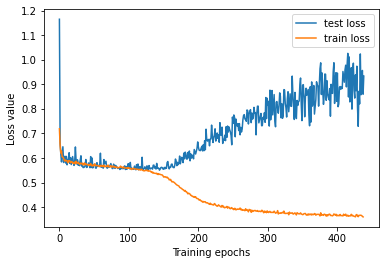

In [13]:
fig, axs = plt.subplots()

axs.plot(test_losses, label="test loss")
axs.plot(train_losses, label="train loss")

axs.set_ylabel("Loss value")
axs.set_xlabel("Training epochs")
axs.legend();

### (cross) validation of the models

In [14]:
# load the validation committors
f = np.load("training_and_validation_data/LiCl_validation_data.npz")
trainset_val = aimmd.TrainSet(n_states=2,
                              descriptors=f["descriptors"],
                              shot_results=f["shot_results"],
                              )

# load the models
final_model_pptrain = aimmd_store.rcmodels["best_model_pptrain"]
final_model_emulate = aimmd_store.rcmodels["final_model_emulation"]

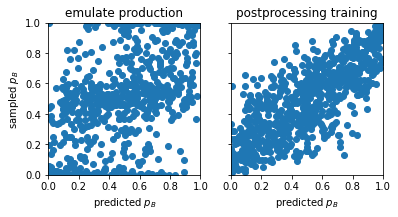

In [15]:
# validate models on untrained committor data
fig, axs = plt.subplots(ncols=2, sharey=True)

for axnum, (ax, mod, title) in enumerate(zip(axs,
                                             [final_model_emulate, final_model_pptrain],
                                             ["emulate production", "postprocessing training"]
                                             )
                                         ):
    p_B = trainset_val.shot_results[:,1] / np.sum(trainset_val.shot_results, axis=1)
    p_B_hat = mod(trainset_val.descriptors)[:,0]
    
    ax.set_title(title)
    ret = ax.scatter(p_B, p_B_hat)
    ax.set_aspect('equal')
    ax.set_xlim(0,1)
    ax.set_xlabel("predicted $p_B$")
    ax.set_ylim(0,1)
    if axnum == 0:
        ax.set_ylabel("sampled $p_B$")


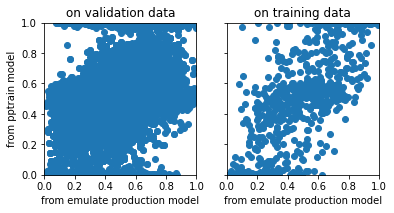

In [16]:
# cross validate the two models against each other
# (this is an easy way of checking for basic consistency even if we do not have validation committor shots available)
fig, axs = plt.subplots(ncols=2, sharey=True)

for axnum, (ax, ts, title) in enumerate(zip(axs, [trainset, trainset_val], ["on validation data", "on training data"])):
    p_B_emul = final_model_emulate(ts.descriptors)[:,0]
    p_B_pptrain = final_model_pptrain(ts.descriptors)[:,0]
    
    ax.set_title(title)
    ret = ax.scatter(p_B_pptrain, p_B_emul)
    ax.set_aspect("equal")
    ax.set_xlim(0,1)
    ax.set_xlabel("from emulate production model")
    ax.set_ylim(0,1)
    if axnum == 0:
        ax.set_ylabel("from pptrain model")
    

## Relative input importance analysis

### (Re)define the symmetry functions parameters from the publication
This enables us to use the utility functions that associate an index with a function and enables interpretation of the relative input importances.

In [17]:
one_frame_atomistic = mdt.load("LiCl_solv.pdb")
cutoff = 1. # consider G5 worst case scenarios for cutoff!
g2_parms = [[200., 0.25], [200., 0.4], [200., 0.55], [200., 0.7], [200., 0.85]] # eta, r_s

g5_etas_rs = [[120., 0.25],
              [120., 0.4],
              [120., 0.55],
              [120., 0.7],
              [120., 0.85]
             ]

zetas = [
        1,
        2,
        4,
        16,
        64,
        ]

g5_parms = [[eta, r_s, zeta, lamb] for (eta, r_s) in g5_etas_rs for zeta in zetas for lamb in [+1., -1.]]

g_parms = [g2_parms, g5_parms]

mol_idxs, solv_idxs = aimmd.coords.symmetry.generate_indices(one_frame_atomistic.topology,
                                                             ['HOH'],
                                                             solvent_atelements=[['O', 'H']],
                                                             reactant_selection='index 0 or index 1')

sf_parms = {'mol_idxs': mol_idxs, 'solv_idxs': solv_idxs, 'g_parms': g_parms,
            'cutoff': cutoff, 'n_per_solv': [[1., 2.]], 'rho_solv': [33.]}

### Postprocessing model

In [18]:
hipr_pptrain = aimmd.analysis.HIPRanalysis(final_model_pptrain, trainset)

In [19]:
hipr_losses_pp, hipr_stds_pp = hipr_pptrain.do_hipr_plus(10)

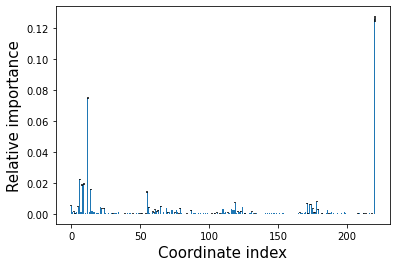

In [20]:
# plot the loss differences as a bar plot
loss_diffs = hipr_losses_pp[:-1] - hipr_losses_pp[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset
plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_stds_pp[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [21]:
# print the 10 most relevant inputs and what they are
loss_diffs = hipr_losses_pp[:-1] - hipr_losses_pp[-1]
max_idxs = np.argsort(loss_diffs)[::-1]  # first get the array that would sort the indices from high importance to low importance

# iterate over the 20 most important contributors
print('reference loss:', hipr_losses_pp[-1])  # this is the loss over the unaltered training set
for idx in max_idxs[:20]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_losses_pp[idx])  # this is the loss we get if we randomize that coordinate, higher means higher importance
    print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))  # this function will extract the parameters for every index
    # it will print the type of transformation, i.e. 'SF' (symmetry function), 'IC' (internal coordinate) or 'customCV'
    # followed by the exact description of the transformation, which naturally varies between SF, IC and customCV
    # for SF we will output (in that order):
    #     the type (G2/G5)
    #     the parameters [eta, r_s, zeta, lambda], where zeta and lambda are applicable only to G5 type SFs
    #     the index of the central atom as given by the topology
    #     the name of the solvent, i.e. solvent resname from above
    #     the atom element of the solvent atom type this coordinate describes

reference loss: 0.5385305285453796

loss for idx 220:  0.664077615737915
('CustomCV', 0)

loss for idx 12:  0.6130991220474243
('SF', ('G5', [120.0, 0.25, 16, -1.0], 0, 'HOH', 'O'))

loss for idx 6:  0.5606916427612305
('SF', ('G5', [120.0, 0.25, 1, -1.0], 0, 'HOH', 'O'))

loss for idx 9:  0.5576014637947082
('SF', ('G5', [120.0, 0.25, 4, 1.0], 0, 'HOH', 'O'))

loss for idx 8:  0.5572261869907379
('SF', ('G5', [120.0, 0.25, 2, -1.0], 0, 'HOH', 'O'))

loss for idx 14:  0.5542119204998016
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 55:  0.552439832687378
('SF', ('G2', [200.0, 0.25], 1, 'HOH', 'O'))

loss for idx 178:  0.5463406860828399
('SF', ('G5', [120.0, 0.25, 64, 1.0], 1, 'HOH', 'H'))

loss for idx 119:  0.5457146406173706
('SF', ('G5', [120.0, 0.25, 4, 1.0], 0, 'HOH', 'H'))

loss for idx 171:  0.5452783823013305
('SF', ('G5', [120.0, 0.25, 1, -1.0], 1, 'HOH', 'H'))

loss for idx 173:  0.5444473206996918
('SF', ('G5', [120.0, 0.25, 2, -1.0], 1, 'HOH', 'H'))


### Emulate production model

In [22]:
hipr_emulate = aimmd.analysis.HIPRanalysis(final_model_emulate, trainset)

In [23]:
hipr_losses_e, hipr_stds_e = hipr_emulate.do_hipr_plus(10)

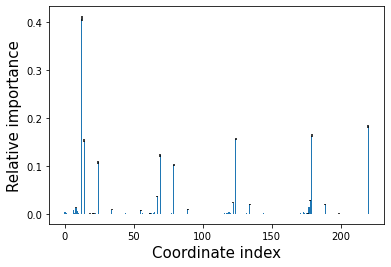

In [24]:
# plot the loss differences as a bar plot
loss_diffs = hipr_losses_e[:-1] - hipr_losses_e[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset
plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_stds_e[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [25]:
# print the 10 most relevant inputs and what they are
loss_diffs = hipr_losses_e[:-1] - hipr_losses_e[-1]
max_idxs = np.argsort(loss_diffs)[::-1]  # first get the array that would sort the indices from high importance to low importance

# iterate over the 20 most important contributors
print('reference loss:', hipr_losses_e[-1])  # this is the loss over the unaltered training set
for idx in max_idxs[:20]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_losses_e[idx])  # this is the loss we get if we randomize that coordinate, higher means higher importance
    print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))  # this function will extract the parameters for every index
    # it will print the type of transformation, i.e. 'SF' (symmetry function), 'IC' (internal coordinate) or 'customCV'
    # followed by the exact description of the transformation, which naturally varies between SF, IC and customCV
    # for SF we will output (in that order):
    #     the type (G2/G5)
    #     the parameters [eta, r_s, zeta, lambda], where zeta and lambda are applicable only to G5 type SFs
    #     the index of the central atom as given by the topology
    #     the name of the solvent, i.e. solvent resname from above
    #     the atom element of the solvent atom type this coordinate describes

reference loss: 0.3388857841491699

loss for idx 12:  0.745354163646698
('SF', ('G5', [120.0, 0.25, 16, -1.0], 0, 'HOH', 'O'))

loss for idx 220:  0.521077138185501
('CustomCV', 0)

loss for idx 179:  0.5018813192844391
('SF', ('G5', [120.0, 0.25, 64, -1.0], 1, 'HOH', 'H'))

loss for idx 124:  0.4949083894491196
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'H'))

loss for idx 14:  0.4916973292827606
('SF', ('G5', [120.0, 0.25, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 69:  0.46061657667160033
('SF', ('G5', [120.0, 0.25, 64, -1.0], 1, 'HOH', 'O'))

loss for idx 24:  0.4459628760814667
('SF', ('G5', [120.0, 0.4, 64, -1.0], 0, 'HOH', 'O'))

loss for idx 79:  0.4411122530698776
('SF', ('G5', [120.0, 0.4, 64, -1.0], 1, 'HOH', 'O'))

loss for idx 67:  0.3753660708665848
('SF', ('G5', [120.0, 0.25, 16, -1.0], 1, 'HOH', 'O'))

loss for idx 178:  0.3668713092803955
('SF', ('G5', [120.0, 0.25, 64, 1.0], 1, 'HOH', 'H'))

loss for idx 122:  0.3622503876686096
('SF', ('G5', [120.0, 0.25, 16, -1.

In [26]:
aimmd_store.close()